# Moving Averge-based Trading Strategy

In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plot
from datetime import datetime
import time

# ----- User Settings 
coin='BTC'

initial_coin = 1
initial_usd = 0
trading_fee = 0.01
 
collectDataFrom = datetime(2014, 1, 1)
#buyAbove='sma7d'
buyAbove='sma50d'
#buyAbove='sma200d'
cryptocompare_api_key='777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'


# ----- User Settings -- end


timestamp = time.time()

time_segments = []
limit=1000

while datetime.timestamp(collectDataFrom) <= timestamp : 
    requestString = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&limit={}&api_key={}&toTs={}'\
    .format(coin, limit, cryptocompare_api_key, timestamp)
    # print("Request : " + requestString)    
    response = requests.get(requestString).text 
    parsed = json.loads(response)
    segment_df = pd.DataFrame(parsed['Data']['Data'])
    prev_timestamp = timestamp
    timestamp = segment_df.loc[0]['time']
    time_segments.append(segment_df)
df= pd.concat(time_segments , axis=0)

df.sort_values(by=['time'], inplace=True)
df.drop_duplicates(inplace=True)
df.set_index('time',inplace=True, verify_integrity = True, drop = False)
df.drop(['volumefrom', 'volumeto','conversionType','conversionSymbol'], axis=1, inplace=True)

df


,time,high,low,open,close
time,,,,,
1325894400,1325894400,7.016,6.380,6.697,6.810
1325980800,1325980800,7.200,6.734,6.810,7.114
1326067200,1326067200,7.191,5.810,7.114,6.326
1326153600,1326153600,6.890,6.001,6.326,6.360
1326240000,1326240000,7.138,6.413,6.360,6.900
...,...,...,...,...,...
1671148800,1671148800,17520.630,16611.580,17359.210,16658.440
1671235200,1671235200,16794.060,16593.680,16658.440,16780.550
1671321600,1671321600,16830.840,16673.020,16780.550,16742.740


In [2]:
#--- Adding 'date' date field 
def unix_to_date(u_time):
        return datetime.utcfromtimestamp(u_time).strftime('%Y-%m-%d')
#print(type(df))    
df['date'] = df['time'].map(unix_to_date)
# -- Reorder to have date on the second position
df = df[['time', 'date', 'open', 'close', 'low', 'high']]
# -- Filter out the older not required dates
filt = (df['time'] >= datetime.timestamp(collectDataFrom) )
df=df[filt]
df

,time,date,open,close,low,high
time,,,,,,
1388534400,1388534400,2014-01-01,805.94,815.94,770.97,829.93
1388620800,1388620800,2014-01-02,815.94,856.91,810.47,886.21
1388707200,1388707200,2014-01-03,856.91,884.26,839.44,888.23
1388793600,1388793600,2014-01-04,884.26,924.69,848.32,932.16
1388880000,1388880000,2014-01-05,924.69,1014.74,911.36,1029.86
...,...,...,...,...,...,...
1671148800,1671148800,2022-12-16,17359.21,16658.44,16611.58,17520.63
1671235200,1671235200,2022-12-17,16658.44,16780.55,16593.68,16794.06
1671321600,1671321600,2022-12-18,16780.55,16742.74,16673.02,16830.84


In [3]:
# Adding Simple Moving Average Columns
df['sma7d'] = df['close'].rolling(7).mean()
df['sma50d'] = df['close'].rolling(50).mean()
df['sma200d'] = df['close'].rolling(200).mean()

# Adding ExponentialMoving Average Columns

df['ema21w'] = df['close'].ewm(span=21*7, adjust=False).mean()

df




,time,date,open,close,low,high,sma7d,sma50d,sma200d,ema21w
time,,,,,,,,,,
1388534400,1388534400,2014-01-01,805.94,815.94,770.97,829.93,NaN,NaN,NaN,815.940000
1388620800,1388620800,2014-01-02,815.94,856.91,810.47,886.21,NaN,NaN,NaN,816.493649
1388707200,1388707200,2014-01-03,856.91,884.26,839.44,888.23,NaN,NaN,NaN,817.409410
1388793600,1388793600,2014-01-04,884.26,924.69,848.32,932.16,NaN,NaN,NaN,818.859148
1388880000,1388880000,2014-01-05,924.69,1014.74,911.36,1029.86,NaN,NaN,NaN,821.506186
...,...,...,...,...,...,...,...,...,...,...
1671148800,1671148800,2022-12-16,17359.21,16658.44,16611.58,17520.63,17289.574286,17688.6124,20639.60235,20338.846208
1671235200,1671235200,2022-12-17,16658.44,16780.55,16593.68,16794.06,17239.768571,17612.2256,20564.59430,20290.761124
1671321600,1671321600,2022-12-18,16780.55,16742.74,16673.02,16830.84,17189.470000,17530.6766,20499.36010,20242.814892


In [4]:
df['hold'] =  df['sma50d'] < df['close']

df['growth'] = df['close'].rolling(window=2).apply(lambda x: x.iloc[1] / x.iloc[0])
df['prev_close'] = df['close'].rolling(window=2).apply(lambda x: x.iloc[0])
df = df.dropna()
df.insert(len(df.columns),'usd_bag',initial_usd)
df.insert(len(df.columns),'coin_bag',initial_coin)
               

In [5]:
#prev_usd_bag = daily_prices_df.iloc[0].usd_bag
#prev_coin_bag = daily_prices_df.iloc[0].coin_bag

def trade_by_ma(row, ma_column='sma50d'):

    isAboveSMA = row['close'] > row[ma_column]
    coin_bag = row['coin_bag']
    usd_bag = row['usd_bag']
    if (isAboveSMA == True ):
    
        if (usd_bag>0):
            coin_bag =  row['coin_bag'] + (1-trading_fee) * row['usd_bag']/row['close']  
            usd_bag = 0
    else:
        if (coin_bag>0):
            usd_bag = row['usd_bag'] + (1-trading_fee) * row['coin_bag']*row['close']
            coin_bag = 0
    return coin_bag,usd_bag 


usd_bag=initial_usd
coin_bag=initial_coin

for index, row in df.iterrows():
    # daily_prices_df.loc[index,['coin_bag','usd_bag']] = [coin_bag, usd_bag]
    row['coin_bag'] = coin_bag
    row['usd_bag'] = usd_bag
    coin_bag, usd_bag = trade_by_ma(row, ma_column=buyAbove)
    df.loc[index,'coin_bag'] = coin_bag
    df.loc[index,'usd_bag'] = usd_bag
        
    # df.loc[index,['coin_bag','usd_bag']] = [ coin_bag, usd_bag] 

df['usd_value'] = df['usd_bag'] + df['coin_bag']*df['close']
df['hodl_usd_value'] = df['close']*initial_coin + initial_usd
df['success_rate'] = df['usd_value'] / df['hodl_usd_value'] 
df.tail(1)

,time,date,open,close,low,high,sma7d,sma50d,sma200d,ema21w,hold,growth,prev_close,usd_bag,coin_bag,usd_value,hodl_usd_value,success_rate
time,,,,,,,,,,,,,,,,,,
1671494400,1671494400,2022-12-20,16442.79,16872.46,16404.94,17028.68,16951.08,17374.5174,20365.3367,20146.61181,False,1.026131,16442.79,23739.251711,0.0,23739.251711,16872.46,1.406982


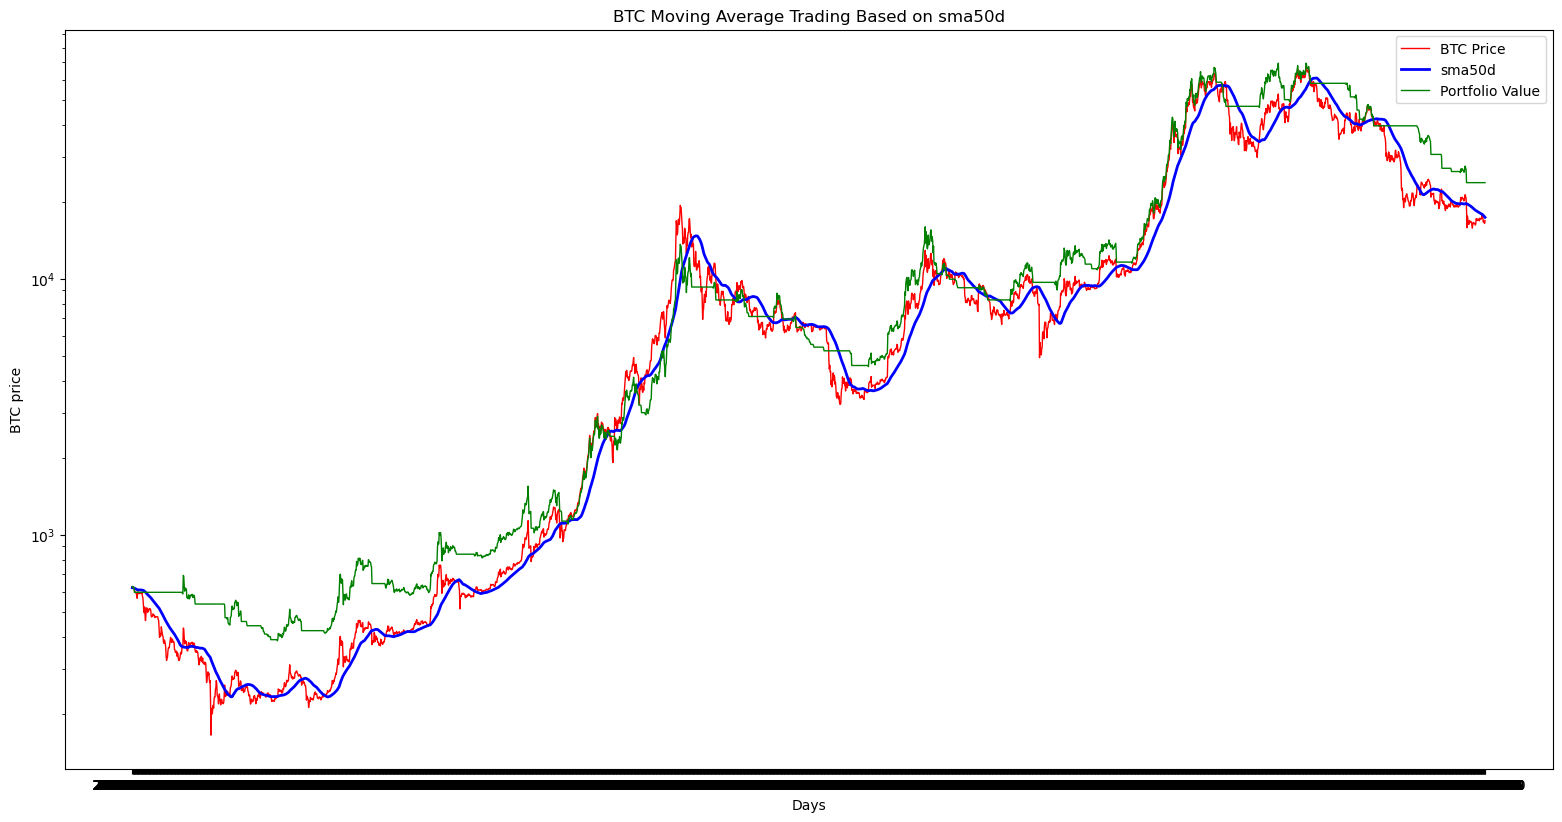

In [6]:

plot.plot(df['date'].tolist(),df['close'].tolist(),'red',label='{} Price'.format(coin), linewidth=1)
plot.plot(df['date'].tolist(),df[buyAbove].tolist(),'blue',label=buyAbove, linewidth=2)
plot.plot(df['date'].tolist(),df['usd_value'].tolist(),'green',label='Portfolio Value', linewidth=1)

plot.title("{} Moving Average Trading Based on {}".format(coin, buyAbove))
plot.ylabel("{} price".format(coin))
plot.xlabel('Days')
plot.legend()
plot.yscale('log')
F = plot.gcf()

# Now check everything with the defaults:
#DPI = F.get_dpi()
#print ("DPI:", DPI)
DefaultSize = F.get_size_inches()
#print ("Default size in Inches", DefaultSize)
#print ("Which should result in a %i x %i Image"%(DPI*DefaultSize[0], DPI*DefaultSize[1]))
# the default is 100dpi for savefig:
#F.savefig("test1.png")
# this gives me a 797 x 566 pixel image, which is about 100 DPI

# Now make the image twice as big, while keeping the fonts and all the
# same size
F.set_size_inches( (DefaultSize[0]*3, DefaultSize[1]*2) )

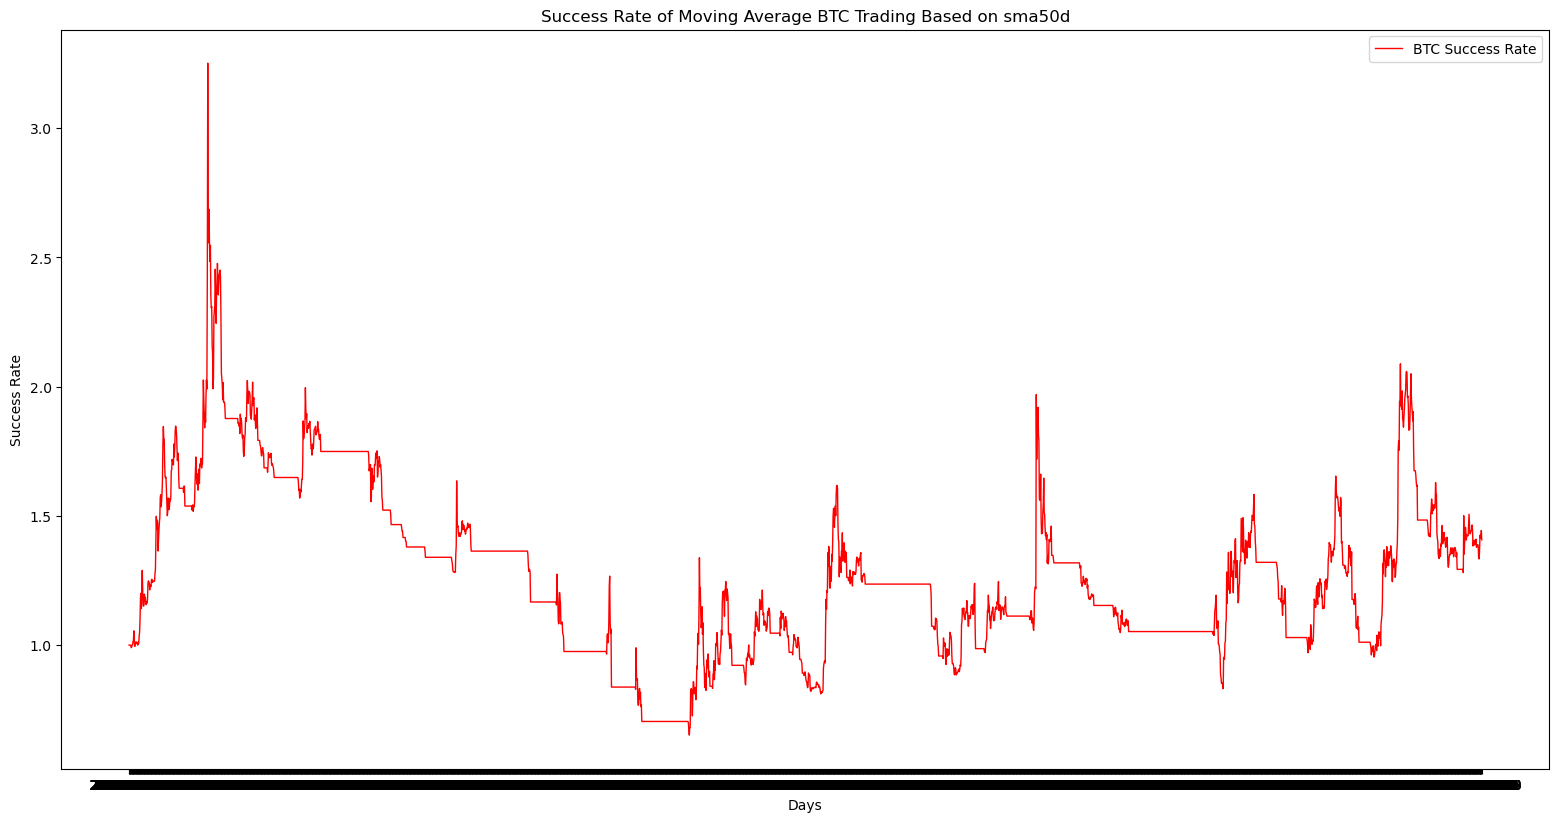

In [7]:

plot.plot(df['date'].tolist(),df['success_rate'].tolist(),'red',label='{} Success Rate'.format(coin), linewidth=1)


plot.title("Success Rate of Moving Average {} Trading Based on {}".format(coin, buyAbove))
plot.ylabel("Success Rate")
plot.xlabel('Days')
plot.legend()
#plot.yscale('log')
F = plot.gcf()

# Now check everything with the defaults:
#DPI = F.get_dpi()
#print ("DPI:", DPI)
DefaultSize = F.get_size_inches()
#print ("Default size in Inches", DefaultSize)
#print ("Which should result in a %i x %i Image"%(DPI*DefaultSize[0], DPI*DefaultSize[1]))
# the default is 100dpi for savefig:
#F.savefig("test1.png")
# this gives me a 797 x 566 pixel image, which is about 100 DPI

# Now make the image twice as big, while keeping the fonts and all the
# same size
F.set_size_inches( (DefaultSize[0]*3, DefaultSize[1]*2) )